In [2]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import subject_data
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import shap
from imblearn.over_sampling import SMOTE


100%|██████████| 226/226 [00:24<00:00,  9.31it/s]
/Users/nikhilnarayanan/Desktop/FYP/REPLACE-BG/my-python3-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cgm = subject_data.df_CGM
cgm['time'] = pd.to_datetime(cgm['time'])

In [4]:
def get_corresponding_day(date_time):
        if date_time.hour < 6:  # If before 6 AM, it belongs to the previous day
            return date_time.date() - timedelta(days=1)
        else:
            return date_time.date()

cgm['corresponding_day'] = cgm['time'].apply(get_corresponding_day)

In [5]:
df = cgm.groupby(['id', 'corresponding_day'])

In [7]:
num_readings = df.size()

<Axes: >

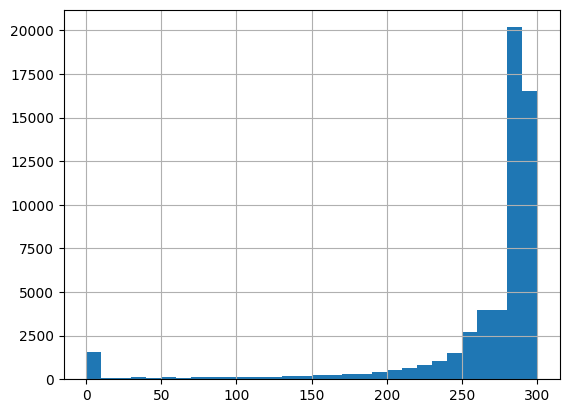

In [13]:
num_readings.hist(bins=30, range=(0,300))

In [15]:
print(len(num_readings))


56798


In [79]:
dgm = cgm[(cgm['time'].dt.hour >= 6) & (cgm['time'].dt.hour < 24)]

In [112]:
filtered_readings = dgm[dgm.groupby(['id', 'corresponding_day']).transform('size') >= 11]


In [115]:
print(filtered_readings.groupby(['id', 'corresponding_day']).size())

id   corresponding_day
2    2015-05-23           12
     2015-05-24           12
     2015-05-25           12
     2015-05-26           12
     2015-05-27           12
                          ..
293  2015-11-22           12
     2015-11-24           12
     2015-11-25           12
     2015-11-28           12
     2015-11-29           12
Length: 35576, dtype: int64


In [110]:
final_hour = filtered_readings[(filtered_readings['time'].dt.hour >= 23) & (filtered_readings['time'].dt.hour < 24)]

In [114]:
filtered_readings = final_hour[final_hour.groupby(['id', 'corresponding_day']).transform('size') >= 11]

In [59]:
print(day_time_filtered.groupby(['id', 'corresponding_day']).size())

id   corresponding_day
2    2015-05-23           214
     2015-05-24           216
     2015-05-25           217
     2015-05-26           218
     2015-05-27           217
                         ... 
293  2015-11-24           211
     2015-11-25           217
     2015-11-27           210
     2015-11-28           216
     2015-11-29           214
Length: 38988, dtype: int64


In [67]:
double_filter = day_time_filtered[day_time_filtered.groupby(['id', 'corresponding_day']).transform('size') > 215]

In [68]:
print(double_filter.groupby(['id', 'corresponding_day']).size())

id   corresponding_day
2    2015-05-24           216
     2015-05-25           217
     2015-05-26           218
     2015-05-27           217
     2015-05-28           217
                         ... 
293  2015-11-17           216
     2015-11-18           218
     2015-11-20           217
     2015-11-25           217
     2015-11-28           216
Length: 27902, dtype: int64


In [78]:
cgm_filtered_af = cgm[cgm[(cgm['time'].dt.hour >= 6) & (cgm['time'].dt.hour < 24)].groupby(['id', 'corresponding_day']).transform('size') > 212]
day_cgm = cgm_filtered_af[(cgm_filtered_af['time'].dt.hour >= 6) & (cgm_filtered_af['time'].dt.hour < 24)]
print(day_cgm.groupby(['id', 'corresponding_day']).size())

/var/folders/6j/zxy_nmpx04gg6ssx89r9gl5h0000gn/T/ipykernel_13783/2048276512.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cgm_filtered_af = cgm[cgm[(cgm['time'].dt.hour >= 6) & (cgm['time'].dt.hour < 24)].groupby(['id', 'corresponding_day']).transform('size') > 212]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [72]:
night = cgm[(cgm['time'].dt.hour >= 0) & (cgm['time'].dt.hour < 6)]
night_hypo = night.groupby(['id', 'corresponding_day']).agg({'bgl': lambda x: (x < 70).mean() > 0.04}).rename(columns={'bgl': 'hypo'}).reset_index()